Adsorción de hidrógeno

In [67]:
using Plots
using DifferentialEquations
using Interact
using WebIO
using Sundials

- El balance de masa será una ecuación diferencial ordinaria para cada nodo. Estamos asumiendo que no hay difusión, y que la convección tiene un efecto de aumentar la presión en todos los puntos del gas atrapado en el medio poroso.

Para ilustrar el uso de ecuaciones diferenciales algebraicas (DAE), resolveremos el siguiente sistema que representa un modelo de parámetros agrupados.

ODE para la masa de hidrógeno en la fase fluida $$ $$

Ec algebraica: $$ n_A = n_0 \exp \left[ {\left(-\frac{RT}{{\alpha + \beta T}}\right)^m \ln^m\left(\frac{p_0}{p}\right)} \right]$$

$$ f(n_A) =  n_A - n_0 \exp {\left(-\frac{RT}{{\alpha + \beta T}}\right)^m \ln^m\left(\frac{p_0}{p}\right)}  $$

Ecuación diferencial 
$$
\frac{d \rho_{H_2}}{d t} = \frac{\dot{m}_s}{V \varepsilon} - \frac{(1 - \varepsilon) \rho_b M_{H_2} }{\varepsilon} \frac{d n_A}{d t}
$$

$n_A$ es u[0], $\rho_{H2}$ es u[1]

Ecuación diferencial de temperatura:
$$ 
(c_{ps} \rho_{s} \varepsilon + \rho_b c_{pp}(1-\varepsilon)) \frac{dT}{dt} = \dot{m_s}h_s + \frac{dm_a}{dt} \frac{\Delta{H}}{M_{H_2}} + h_f A_e (T-T_f)
$$

In [68]:
# Non lumped version of the model parameters
# Adsorption 
ε = 0.49 # Porosity 
ρ_b = 517.6 # Activated carbon density / kg m^-3
MW = 2.0159 * 10^-3 # kg/mol  
V = 2.4946e-3 # Tank volume
ṁₛ = 2.354e-9 # kg / s
Tᵢ = 293.15 # K

# Equilibrium parameters
R = 8.314 # Gas constant / J / mol / K
α = 3080.0 # Isotherm parameter / K
β = 18.9 # Isotherm parameter / -
p₀ = 1.47e9 # Saturation pressure / Pa
n₀ = 71.6 # Cantidad limite de adsorcion (mol kg-1)
m = 2.0; # magical parameter

In [69]:
# Aditional parameters for lumped model
ΔH = 3185 # Isostoric heat of adsorption / J / mol 
Aₑ = 0.1277 # Heat transfer area / m^2
h_f = 36 # Heat transfer coefficient / W / m^2 / K 
cₚₛ = 10167 # Heat capacity of the hydrogen / J / kg / K
cₚ_b = 825 # Heat capacity of the activated carbon / J / kg / K
hₛ = 3986.8 # Enthalpy of the hydrogen / J / kg
T_f = 293.15 # Temperature of the exterior / K

293.15

Para mejoras futuras

http://www.coolprop.org/coolprop/wrappers/Julia/

In [70]:
function adsorption(out, du, u, par, t)
    # Unpacking variables
    nₐ, ρ, p, T = u
    
   #print(exp(-(R*T/(α+β*T))^m * (log(p₀/p))^m ))

    out[1] = nₐ - n₀ * exp( - (R*T/(α+β*T))^m * (log(p₀/p))^m ) 
    
    # H2 mass balance
    out[2] = du[2] - ( ṁₛ/(V*ε) - (1-ε)/(ε) * ρ_b * MW * du[1] ) 
    
    # p-rho-T through ideal gas
    out[3] = p - ρ*R*T / MW

    out[4] = (cₚₛ*ρ*ε + cₚ_b*ρ_b*(1-ε)) * du[4] - (h_f*Aₑ*(T - T_f)) - (hₛ*ṁₛ) - MW*ρ_b*ΔH*du[1]
    
    # print("\n p_calc", ρ*R*T / MW)
    
    #print("\nout1", out[1])
    #print("\nout2", out[2])
    #print("\nout3", out[3])
    #print("\np = ",p,"\n = rho",ρ, "\nR =",R,"\nT =",T,"\nMW =",MW)
    
end

adsorption (generic function with 1 method)

In [71]:
# Hydrogen at 1 atm at the beginning of the charging period
pᵢ = 1e5 # Pa
ρ₀ = pᵢ/( (R/MW) * Tᵢ)

# Consistent initial conditions for adsorbed mass in hydrogen
# this formula MUST be used if no mass transfer coefficient is used
# (instantaneous equilibrium)
na₀ = n₀ * exp( - (R*T/(α+β*Tᵢ))^m * (log(p₀/pᵢ))^m ) 

u₀ = [na₀, ρ₀ , pᵢ, Tᵢ]

# Initial estimates of temporal variables
du₀ = [1e-4, 1e-4, 1e-4, 1e-4]

# Tiempo de integración
tspan = (0.0, 3600*100)

# Variables that appear explicitely as derivatives du
differential_vars = [true, true, false, true]

# Differential algebraic problem for sundials
prob = DAEProblem(adsorption, du₀, u₀, tspan, differential_vars=differential_vars)

sol_2= solve(prob,IDA());

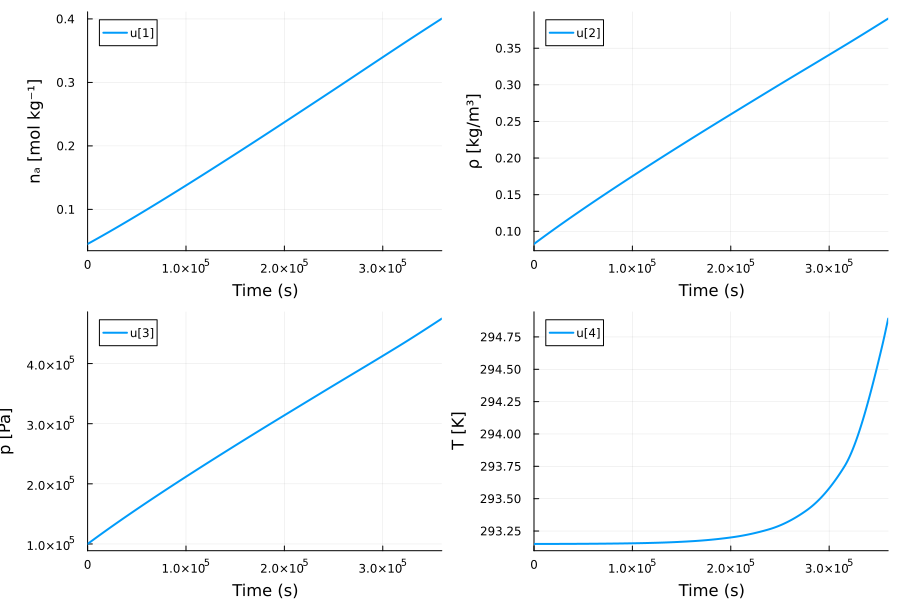

In [73]:
plot(sol_2, layout = 4, ylabel = ["nₐ [mol kg⁻¹]" "ρ [kg/m³]" "p [Pa]" "T [K]"], xlabel = "Time (s)", lw = 2, size = (900, 600))